In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # df processing, CSV file I/O (e.g. pd.read_csv)

# Input df files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e1/sample_submission.csv
/kaggle/input/playground-series-s5e1/train.csv
/kaggle/input/playground-series-s5e1/test.csv


In [2]:
import pandas as pd 


df = pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv')

**Before getting started on the forecasting part it is important to take a look at what kind of data we are working with**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


# Data Cleaning

**It is important to clean the data properly before forecasting**

**Data cleaning steps I followed are given below**
* Getting rid of duplicated data - Duplicates can distort trends, patterns, and correlations crucial for accurate modeling and forecasting. But in this we are not going into trend/pattern analysis because the problem doesn't require us to do so
* Getting rid of NA value
  
  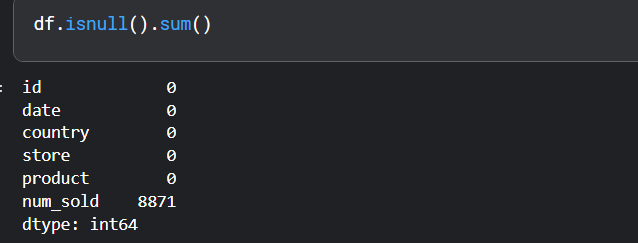

  
  Only NAN values present in this column so got rid of the rows which has them because the column itself is valuable insight for forecasting

In [4]:
df.duplicated().sum()

0

In [5]:
df.isnull().sum()

id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64

In [6]:
df = df.dropna(subset=['num_sold'])

In [7]:
df.isnull().sum()

id          0
date        0
country     0
store       0
product     0
num_sold    0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221259 entries, 1 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        221259 non-null  int64  
 1   date      221259 non-null  object 
 2   country   221259 non-null  object 
 3   store     221259 non-null  object 
 4   product   221259 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 11.8+ MB


In [9]:
df['date'].head()

1    2010-01-01
2    2010-01-01
3    2010-01-01
4    2010-01-01
5    2010-01-01
Name: date, dtype: object

# Converting to Numpy datetime format

**Why this step is necessary:**

1. Ensures Consistent Format: Converts string or other formats into a uniform datetime format for analysis.
   
2. Enables Time-Based Operations: Allows you to perform time series operations such as sorting, filtering by date, resampling, or extracting specific components (e.g., year, month, day).

3. Improves Efficiency: Many Pandas time-related methods work more efficiently with datetime objects than with strings.

Therefore converting to datetime is a must.

In [10]:
df['date'] = pd.to_datetime(df['date'])

In [11]:
df['date'].head()

1   2010-01-01
2   2010-01-01
3   2010-01-01
4   2010-01-01
5   2010-01-01
Name: date, dtype: datetime64[ns]

In [12]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek

# Reducing multicollinearity 

* This ensures , 

      1. Better Stability
      2. Reduce overfitting
      3. Improve Forecasting Accuracy

In [13]:
df = pd.get_dummies(df , columns  = ['country' , 'store' , 'product'] , drop_first = True)

In [14]:
df.head()

,id,date,num_sold,year,month,day,day_of_week,country_Finland,country_Italy,country_Kenya,country_Norway,country_Singapore,store_Premium Sticker Mart,store_Stickers for Less,product_Kaggle,product_Kaggle Tiers,product_Kerneler,product_Kerneler Dark Mode
1,1,2010-01-01,973.0,2010,1,1,4,False,False,False,False,False,False,False,True,False,False,False
2,2,2010-01-01,906.0,2010,1,1,4,False,False,False,False,False,False,False,False,True,False,False
3,3,2010-01-01,423.0,2010,1,1,4,False,False,False,False,False,False,False,False,False,True,False
4,4,2010-01-01,491.0,2010,1,1,4,False,False,False,False,False,False,False,False,False,False,True
5,5,2010-01-01,300.0,2010,1,1,4,False,False,False,False,False,False,True,False,False,False,False


In [15]:
x = df.drop(columns = ['id' , 'date' , 'num_sold'])
y = df['num_sold']

In [16]:
from sklearn.model_selection import train_test_split

x_train , x_test , y_train , y_test = train_test_split(x , y , test_size = 0.2 , random_state = 42)

# Model Selection 

**Used RandomForest because low dimensions + handles categorical variables automatically**

In [17]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state = 42)
model.fit(x_train , y_train)

RandomForestRegressor(random_state=42)

In [18]:
y_pred = model.predict(x_test)

In [19]:
import numpy as np

def mean_absolute_percentage_error(y_true , y_pred):

    return np.mean(np.abs((y_true - y_pred) / y_true ))  * 100

mape = mean_absolute_percentage_error(y_test , y_pred)

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 5.17%


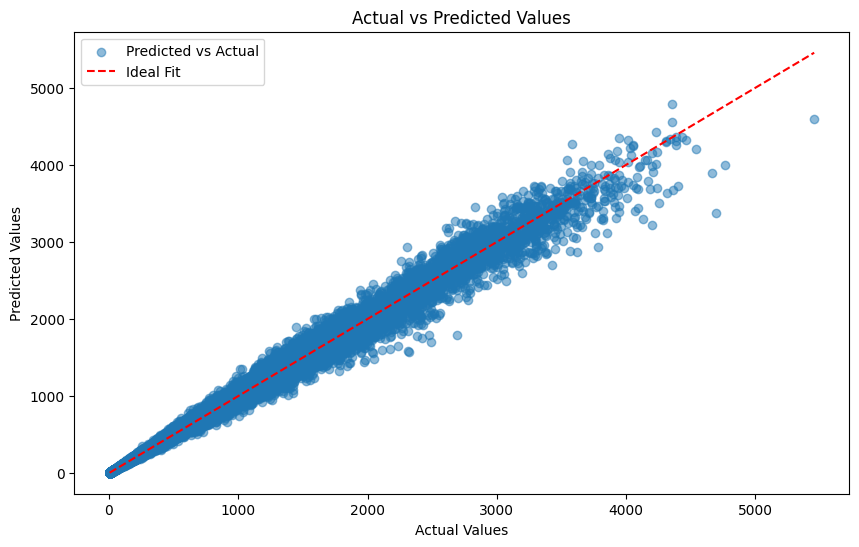

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Ideal Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.show()

In [21]:
importances = model.feature_importances_

indices = np.argsort(importances)[::-1]

features = x.columns 

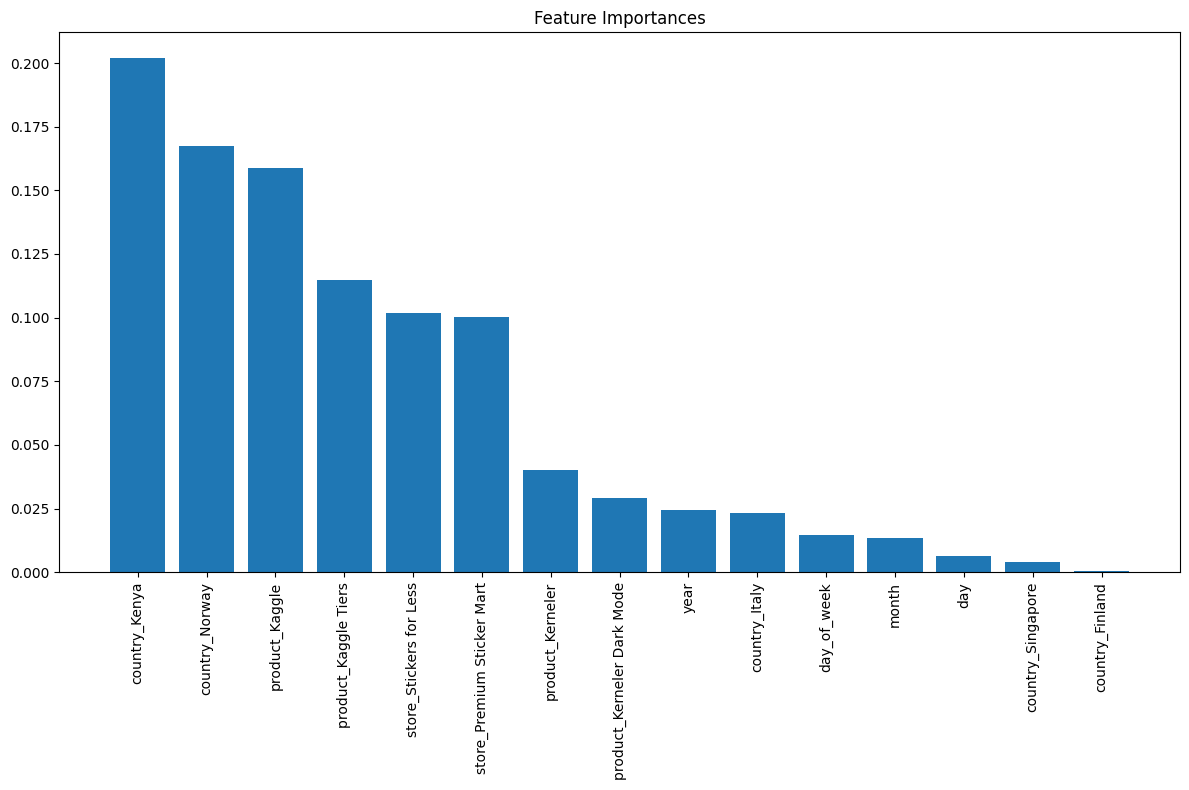

In [22]:
plt.figure(figsize=(12, 8))
plt.bar(range(x.shape[1]), importances[indices], align="center")
plt.xticks(range(x.shape[1]), [features[i] for i in indices], rotation=90)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

In [23]:
test_df = pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv')

In [24]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98550 entries, 0 to 98549
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       98550 non-null  int64 
 1   date     98550 non-null  object
 2   country  98550 non-null  object
 3   store    98550 non-null  object
 4   product  98550 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [25]:
test_df.isnull().sum()

id         0
date       0
country    0
store      0
product    0
dtype: int64

In [26]:
test_df['date'] = pd.to_datetime(test_df['date'])

In [27]:
test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['day_of_week'] = test_df['date'].dt.dayofweek
test_df = pd.get_dummies(test_df, columns=['country', 'store', 'product'], drop_first=True)

In [28]:
X_test_final = test_df.drop(columns=['id', 'date'])
X_test_final = X_test_final.reindex(columns=x.columns, fill_value=0)

In [29]:
test_df['num_sold'] = model.predict(X_test_final)

In [30]:
test_df[['id', 'num_sold']].to_csv("submission.csv", index=False)